In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import sqlite3
import os

In [2]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,accuracy_score,roc_auc_score,roc_curve

In [3]:
con = sqlite3.connect('C:/Users/karth/Desktop/AML/All Assignments/Assignment K-nn on Amazon Fine Food Reviews/final.sqlite')

In [4]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE !=3
''', con)

In [5]:
df.shape

(364173, 12)

### Time based sorting

In [6]:
df = df.sort_values('Time', axis=0)

### Replacing scores

In [7]:
df.Score.replace(to_replace=[1,2],value=0, inplace=True)

In [8]:
df.Score.replace(to_replace=[4,5], value=1, inplace=True)

In [9]:
df.Score.value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [10]:
CleanedText = df.CleanedText[0:100000]

In [11]:
CleanedText.shape

(100000,)

In [12]:
x = df.Score[60000:80000]

In [13]:
x.shape

(20000,)

In [14]:
y = pd.DataFrame(data=x,)

In [15]:
y.Score.value_counts()

1    17258
0     2742
Name: Score, dtype: int64

In [16]:
x_train = CleanedText[0:60000]
x_cv = CleanedText[60000:80000]
x_test = CleanedText[80000:100000]

y_train = df.Score.values[0:60000]
y_cv = df.Score.values[60000:80000]
y_test = df.Score.values[80000:100000]

### Bag of words

In [17]:
countvect = CountVectorizer(max_features=2000, min_df=5)

In [18]:
bow = countvect.fit(x_train)

In [19]:
train_bowcount = bow.transform(x_train)

In [20]:
test_bowcount = bow.transform(x_test)

In [21]:
cv_bowcount = bow.transform(x_cv)

In [22]:
train_bowcount

<60000x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 1542762 stored elements in Compressed Sparse Row format>

### naive bayes  - training

In [23]:
alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [24]:
f1=[]
count = 0
for i in alpha:
    nbc = MultinomialNB(alpha=i)
    nbc.fit(train_bowcount, y_train)
    pred = nbc.predict(cv_bowcount)
    f1.append(f1_score(y_cv, pred, average='micro')*(100))
    print('f1_score for alpha={} is {}'.format(i, ((f1[count]))))
    count +=1

f1_score for alpha=0.0001 is 89.595
f1_score for alpha=0.001 is 89.59
f1_score for alpha=0.01 is 89.59
f1_score for alpha=0.1 is 89.60000000000001
f1_score for alpha=1 is 89.605
f1_score for alpha=10 is 89.56
f1_score for alpha=100 is 88.36500000000001
f1_score for alpha=1000 is 86.285
f1_score for alpha=10000 is 86.29


Text(0.5,1,'ALPHA VS F1 SCORE')

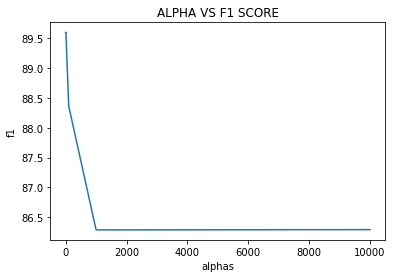

In [25]:
plt.plot(alpha, f1)
plt.xlabel("alphas")
plt.ylabel("f1")
plt.title('ALPHA VS F1 SCORE')

In [26]:
print(precision_score(y_cv, pred)*100, 'is the precision')
print(recall_score(y_cv, pred)*100, 'is the recall')
print(f1_score(y_cv, pred)*100, 'is the f1 score')
# print(roc_auc_score(y_test, pred), 'is the roc_auc_score')

86.29 is the precision
100.0 is the recall
92.6405067368082 is the f1 score


In [27]:
accuracy_score(y_cv, pred, normalize=True)*100

86.29

In [28]:
cmat = (confusion_matrix(y_cv, pred))

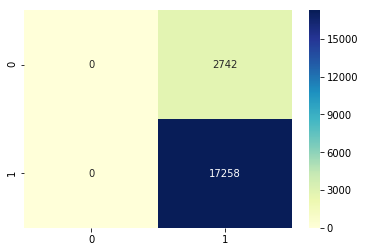

In [29]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### Testing

In [30]:
nbc = MultinomialNB(alpha=1)
nbc.fit(train_bowcount, y_train)
pred = nbc.predict(test_bowcount)
f1 = f1_score(y_test, pred, average='micro')*float(100)
print('f1score for alpha=0.01 in test data is %d' %(f1))

f1score for alpha=0.01 in test data is 89


In [31]:
cmat = confusion_matrix(y_test, pred)

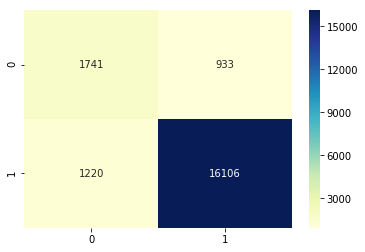

In [32]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [33]:
print(precision_score(y_test, pred)*100, 'is the precision')
print(recall_score(y_test, pred)*100, 'is the recall')
print(f1_score(y_test, pred)*100, 'is the f1 score')
print(roc_auc_score(y_test, pred), 'is the roc_auc_score')

94.52432654498504 is the precision
92.95855939051137 is the recall
93.73490469954896 is the f1 score
0.790335055740889 is the roc_auc_score


In [34]:
accuracy_score(y_test, pred, normalize=True)*100

89.235

In [35]:
from sklearn.metrics import roc_curve

In [36]:
from sklearn import metrics

In [37]:
fpr, tpr, threshold = roc_curve(y_test, pred)

In [38]:
roc_auc = metrics.auc(fpr, tpr)

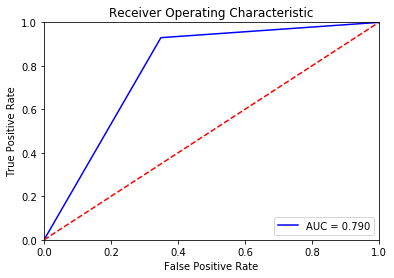

In [39]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Tf-idf approach

In [49]:
tfidfvect = TfidfVectorizer(max_features=5000, min_df=2)

In [50]:
tfidf = tfidfvect.fit(x_train)

In [51]:
train_tfidf = tfidf.transform(x_train)
test_tfidf = tfidf.transform(x_test)
cv_tfidf = tfidf.transform(x_cv)

In [52]:
train_tfidf.shape

(60000, 5000)

In [53]:
test_tfidf.shape

(20000, 5000)

In [54]:
cv_tfidf.shape

(20000, 5000)

### naive bayes - training

In [55]:
F1=[]
count = 0
for i in (alpha):
    nbc = MultinomialNB(alpha=i)
    nbc.fit(train_tfidf, y_train)
    pred = nbc.predict(cv_tfidf)
    F1.append(f1_score(y_cv, pred, average='micro'))
    print('fbeta_score for alpha={} is {}'.format(i, (F1[count])))
    count +=1

fbeta_score for alpha=0.001 is 0.8829
fbeta_score for alpha=0.01 is 0.88295
fbeta_score for alpha=0.01 is 0.88295
fbeta_score for alpha=0.1 is 0.88285
fbeta_score for alpha=1 is 0.8785
fbeta_score for alpha=10 is 0.8632


Text(0.5,1,'ALPHA VS F1')

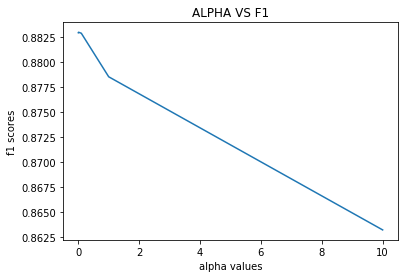

In [56]:
plt.plot(alpha, F1)
plt.xlabel('alpha values')
plt.ylabel('f1 scores')
plt.title('ALPHA VS F1')

In [57]:
cmat = (confusion_matrix(y_cv, pred))

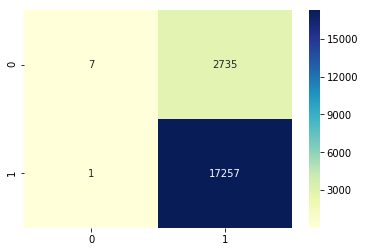

In [58]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### testing

In [59]:
nbc = MultinomialNB(alpha=0.01)
nbc.fit(train_tfidf, y_train)
pred = nbc.predict(test_tfidf)
f1score = f1_score(y_test, pred, average='micro')*100
print('f1 score for the optimal alpha is {}'.format(f1score))

f1 score for the optimal alpha is 88.44999999999999


In [60]:
cmat = (confusion_matrix(y_test, pred))

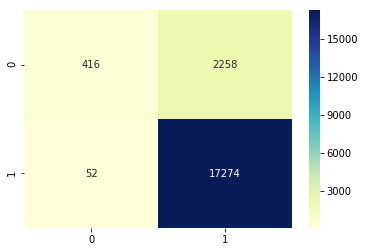

In [61]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [62]:
print(precision_score(y_test, pred)*100, 'is the precision')
print(recall_score(y_test, pred)*100, 'is the recall')
print(f1_score(y_test, pred)*100, 'is the f1 score')

88.43948392381733 is the precision
99.69987302320213 is the recall
93.73270389060718 is the f1 score


In [63]:
accuracy_score(y_cv, pred, normalize=True)*100

84.61

### Since our model is underfitting badly, We will use SMOTE and nearmiss for upsampling and downsampling
### and reduce the high bias in our model

### SMOTE

In [89]:
from collections import Counter

In [64]:
from sklearn.linear_model import LogisticRegression

In [100]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [101]:
smote = SMOTE(n_jobs=2, random_state=10, ratio=1.0)

In [102]:
x_sampled,y_sampled = smote.fit_resample(train_tfidf, y_train)

In [103]:
x_sampled.shape

(106294, 5000)

In [104]:
y_sampled.shape

(106294,)

In [92]:
Counter(y_sampled)

Counter({1: 53147, 0: 53147})

In [119]:
accuracy=[]
count = 0
for i in (alpha):
    nbc = MultinomialNB(alpha=i)
    nbc.fit(x_sampled, y_sampled)
    pred = nbc.predict(cv_tfidf)
    accuracy.append(accuracy_score(y_cv, pred, normalize=True)*100)
    print('accuracy score for alpha={} is {}'.format(i, accuracy[count]))
    count +=1

accuracy score for alpha=0.0001 is 86.235
accuracy score for alpha=0.001 is 86.21
accuracy score for alpha=0.01 is 86.24000000000001
accuracy score for alpha=0.1 is 86.28
accuracy score for alpha=1 is 86.15
accuracy score for alpha=10 is 85.61


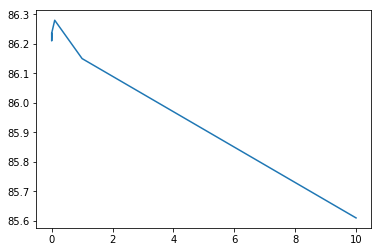

In [120]:
plt.plot(alpha, accuracy)

In [121]:
print(precision_score(y_cv, pred)*100, 'is the precision on cv set')
print(recall_score(y_cv, pred)*100, 'is the recall on cv set')
print(fbeta_score(y_cv, pred, beta=0.5)*100, 'is the fbeta score on cv set')

97.16609813697193 is the precision on cv set
85.8268629041604 is the recall on cv set
94.66472377738579 is the fbeta score on cv set


In [122]:
cmat = (confusion_matrix(y_cv, pred))

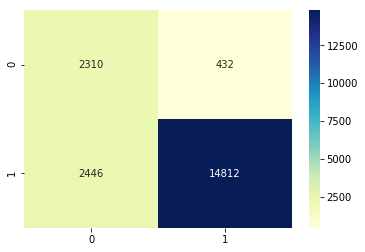

In [123]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [143]:
nbc = MultinomialNB(alpha=0.1)
nbc.fit(x_sampled, y_sampled)
pred = nbc.predict(test_tfidf)
f1score = f1_score(y_test, pred, average='micro')*100
print('f1 score for the optimal alpha is {}'.format(f1score))

f1 score for the optimal alpha is 85.485


In [144]:
print(precision_score(y_test, pred)*100, 'is the precision on test set')
print(recall_score(y_test, pred)*100, 'is the recall on test set')
print(fbeta_score(y_test, pred, beta=0.5)*100, 'is the fbeta score on test set')

96.5528371312375 is the precision on test set
86.32690753780446 is the recall on test set
94.31832513557826 is the fbeta score on test set


In [145]:
cmat = (confusion_matrix(y_test, pred))

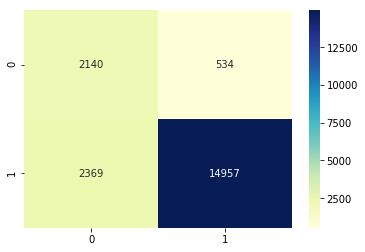

In [146]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### nearmiss

In [147]:
nm = NearMiss(n_jobs=2)

In [148]:
x_down,y_down = nm.fit_resample(train_tfidf, y_train)

In [149]:
Counter(y_down)

Counter({0: 6853, 1: 6853})

In [153]:
alphai=[0.001,0.01,0.1,1,10,100,1000,10000]
accuracy =[]
count = 0
for i in (alphai):
    nbc = MultinomialNB(alpha=i)
    nbc.fit(x_down, y_down)
    pred = nbc.predict(cv_tfidf)
    accuracy.append(accuracy_score(y_cv, pred, normalize=True)*100)
    print('accuracy score for alpha={} is {}'.format(i, (accuracy[count])))
    count +=1

accuracy score for alpha=0.001 is 68.05499999999999
accuracy score for alpha=0.01 is 68.375
accuracy score for alpha=0.1 is 69.16499999999999
accuracy score for alpha=1 is 71.655
accuracy score for alpha=10 is 74.65
accuracy score for alpha=100 is 76.31
accuracy score for alpha=1000 is 76.34
accuracy score for alpha=10000 is 76.28


Text(0,0.5,'accuracy')

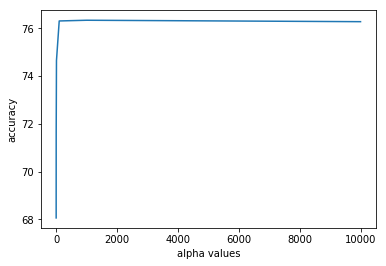

In [154]:
plt.plot(alphai, accuracy)
plt.xlabel('alpha values')
plt.ylabel('accuracy')

In [155]:
nbc = MultinomialNB(alpha=1000)
nbc.fit(x_down, y_down)
pred = nbc.predict(test_tfidf)
f1score = f1_score(y_test, pred, average='micro')*100
print('f1 score for the optimal alpha is {}'.format(f1score))

f1 score for the optimal alpha is 76.015


In [156]:
cmat = (confusion_matrix(y_test, pred))

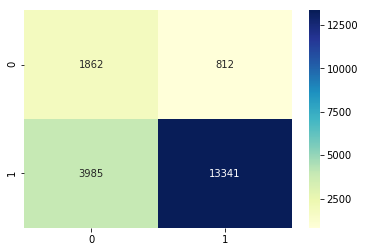

In [157]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

# feature selection part

### finding feature importance for positive and negative reviews

In [25]:
positivereviews = df[df.Score == 1]

In [26]:
positivereviews.shape

(307063, 12)

In [27]:
positivereviews.Score.value_counts()

1    307063
Name: Score, dtype: int64

In [28]:
pos_y = positivereviews.Score

In [29]:
pos_y.shape

(307063,)

In [30]:
pos_y.value_counts()

1    307063
Name: Score, dtype: int64

In [31]:
negativereviews = df[df.Score == 0]

In [32]:
neg_y = negativereviews.Score

In [33]:
negativereviews.Score.value_counts()

0    57110
Name: Score, dtype: int64

In [34]:
countvect = CountVectorizer(stop_words='english', min_df=3)

In [35]:
positivebow = countvect.fit(positivereviews.CleanedText)

In [36]:
pos_xtrain = positivebow.transform(positivereviews.CleanedText)

### nb classifier

In [37]:
import warnings
warnings.filterwarnings('ignore')
nb = MultinomialNB(alpha=0)
nb.fit(pos_xtrain, pos_y)

MultinomialNB(alpha=0, class_prior=None, fit_prior=True)

### decision tree classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
clf = DecisionTreeClassifier()

In [50]:
clf.fit(pos_xtrain, pos_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
positivereviews.Score.value_counts()

1    307063
Name: Score, dtype: int64

In [39]:
features = positivebow.get_feature_names()

In [40]:
len(features)

24660

In [41]:
nb.coef_

array([[-12.86799744, -15.02748169, -13.48703665, ..., -13.9288694 ,
        -14.04665244, -15.02748169],
       [-10.11293778, -10.11293778, -10.11293778, ..., -10.11293778,
        -10.11293778, -10.11293778]])

In [42]:
poscoef = nb.coef_

In [43]:
posfeaturelog = nb.feature_log_prob_

In [44]:
posfeaturelog.shape

(2, 24660)

In [45]:
nb.feature_log_prob_

array([[-12.86799744, -15.02748169, -13.48703665, ..., -13.9288694 ,
        -14.04665244, -15.02748169],
       [-10.11293778, -10.11293778, -10.11293778, ..., -10.11293778,
        -10.11293778, -10.11293778]])

In [46]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    feature_log_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    top = zip(feature_log_with_fns[:n], feature_log_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [47]:
(show_most_informative_features(positivebow, nb))

	-15.0275	aaaah          		-4.2812	like           
	-15.0275	aarp           		-4.3596	tast           
	-15.0275	abb            		-4.4937	good           
	-15.0275	abe            		-4.5233	flavor         
	-15.0275	aberdeen       		-4.5421	love           
	-15.0275	ablaz          		-4.5756	great          
	-15.0275	ablut          		-4.5756	use            
	-15.0275	abotu          		-4.6174	product        
	-15.0275	abouy          		-4.7551	tri            
	-15.0275	abrad          		-4.7910	tea            
	-15.0275	abraham        		-4.8531	coffe          
	-15.0275	absens         		-4.8999	make           
	-15.0275	absolu         		-5.0486	food           
	-15.0275	acc            		-5.1528	amazon         
	-15.0275	acces          		-5.2070	time           
	-15.0275	accompany      		-5.2261	buy            
	-15.0275	acct           		-5.2539	realli         
	-15.0275	accupuncturist 		-5.2676	eat            
	-15.0275	acd            		-5.3314	price          
	-15.0275	acerb          		-5.3

In [52]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    feature_log_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = zip(feature_log_with_fns[:n], feature_log_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [53]:
show_most_informative_features(positivebow, clf)

	0.0000	aaa            		0.0000	zzz            
	0.0000	aaaah          		0.0000	zyrtec         
	0.0000	aaah           		0.0000	zym            
	0.0000	aaf            		0.0000	zylitol        
	0.0000	aafco          		0.0000	zwieback       
	0.0000	aah            		0.0000	zurich         
	0.0000	aamazon        		0.0000	zupreem        
	0.0000	aand           		0.0000	zumba          
	0.0000	aarp           		0.0000	zulu           
	0.0000	ab             		0.0000	zuko           
	0.0000	aback          		0.0000	zuke           
	0.0000	abandon        		0.0000	zuchinni       
	0.0000	abat           		0.0000	zuchini        
	0.0000	abb            		0.0000	zuccini        
	0.0000	abba           		0.0000	zucchini       
	0.0000	abbey          		0.0000	zsweet         
	0.0000	abbi           		0.0000	zowi           
	0.0000	abbott         		0.0000	zout           
	0.0000	abbrevi        		0.0000	zour           
	0.0000	abc            		0.0000	zotz           


In [183]:
negativebow = countvect.fit(negativereviews.CleanedText)

In [184]:
neg_xtrain = negativebow.transform(negativereviews.CleanedText)

In [185]:
nbc = MultinomialNB(alpha=0)
nbc.fit(neg_xtrain, negativereviews.Score)

MultinomialNB(alpha=0, class_prior=None, fit_prior=True)

In [186]:
nbc.feature_log_prob_

array([[-11.95069641, -12.43620422, -11.0191382 , ..., -11.47112333,
        -10.58382013, -13.1293514 ],
       [ -9.41262794,  -9.41262794,  -9.41262794, ...,  -9.41262794,
         -9.41262794,  -9.41262794]])

In [187]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    feature_log_with_fns = sorted(zip(clf.feature_log_prob_[0], feature_names))
    top = zip(feature_log_with_fns[:n], feature_log_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [188]:
show_most_informative_features(negativebow, nbc)

	-13.4170	abat           		-4.0652	tast           
	-13.4170	abhorr         		-4.1323	like           
	-13.4170	absorbt        		-4.2218	product        
	-13.4170	academi        		-4.6360	flavor         
	-13.4170	accentu        		-4.7315	tri            
	-13.4170	acct           		-4.8802	use            
	-13.4170	acidifi        		-4.8984	good           
	-13.4170	ack            		-4.9215	coffe          
	-13.4170	adaptogen      		-4.9869	buy            
	-13.4170	adept          		-5.0535	order          
	-13.4170	adio           		-5.0637	food           
	-13.4170	adit           		-5.1540	tea            
	-13.4170	adorn          		-5.1740	amazon         
	-13.4170	adrenalin      		-5.2276	box            
	-13.4170	advent         		-5.3218	make           
	-13.4170	advisori       		-5.3263	time           
	-13.4170	aerosol        		-5.3406	bag            
	-13.4170	affirm         		-5.3557	eat            
	-13.4170	affront        		-5.3684	realli         
	-13.4170	agian          		-5.4

In [44]:
hyperparam = [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000,10000, 100000]

In [46]:
train_bowcount.shape

(60000, 2000)

In [45]:
auc_vals=[] #saving auc values for graph plot
for i in hyperparam:
    print("For alpha = {} ".format(i))
    nb = MultinomialNB(alpha=i)

    # fitting the model on crossvalidation train
    nb.fit(train_bowcount, y_train)

    # predict probabilities
    probs_train = nb.predict_proba(train_bowcount)
    probs_cv = nb.predict_proba(cv_bowcount)

    # keep probabilities for the positive outcome only
    probs_train = probs_train[:, 1]
    probs_cv = probs_cv[:, 1]

    # calculate AUC
    auc_train = roc_auc_score(y_train, probs_train)
    auc_cv= roc_auc_score(y_cv, probs_cv)
    
    print('AUC on train: %.3f' % auc_train)
    print('AUC on Cross Validation: %.3f' % auc_cv)
    auc_vals.append((auc_train,auc_cv))
    print("="*15)

For alpha = 1e-05 
AUC on train: 0.912
AUC on Cross Validation: 0.907
For alpha = 0.0001 
AUC on train: 0.912
AUC on Cross Validation: 0.907
For alpha = 0.001 
AUC on train: 0.912
AUC on Cross Validation: 0.906
For alpha = 0.01 
AUC on train: 0.912
AUC on Cross Validation: 0.906
For alpha = 0.1 
AUC on train: 0.912
AUC on Cross Validation: 0.906
For alpha = 1 
AUC on train: 0.912
AUC on Cross Validation: 0.907
For alpha = 10 
AUC on train: 0.909
AUC on Cross Validation: 0.906
For alpha = 100 
AUC on train: 0.828
AUC on Cross Validation: 0.826
For alpha = 1000 
AUC on train: 0.605
AUC on Cross Validation: 0.598
For alpha = 10000 
AUC on train: 0.553
AUC on Cross Validation: 0.547
For alpha = 100000 
AUC on train: 0.543
AUC on Cross Validation: 0.537
